# Quantify **Organelle Morphology** - part 2.1
--------------------
Now that all organelles and masks are segmented, we can begin to quantify features of organelle **composition**, **morphology**, **interactions**, and **distribution**. 


## **OBJECTIVE**
### <input type="checkbox"/> Quantify ***organelle composition and morphology***
In this notebook, the logic for quantifying **organelle composition** (how much of each organelle is present) and **morphology** (individual size and shape) is outlined.


--------
## **Organelle Morphology**

### summary of steps

🛠️ **BUILD FUNCTION PROTOTYPE**

- **`0`** - Apply Cell Mask *(preliminary step)*

- **`1`** - Build the list of measurements we want to include from regionprops 

- **`2`** - Add additional measurements as *"extra_properties"* with custom functions.

- **`3`** - Run regionprops and export values as a pandas dataframe

- **`4`** - Add additional measurements
    - surface area
    - surface area to volume ratio

⚙️ **EXECUTE FUNCTION PROTOTYPE**

- Define `_get_org_morphology_3D` function
- Run `_get_org_morphology_3D` function
    - scaled and unscaled
- Compare to finalized `get_org_morphology_3D` function

## **IMPORTS**

#### &#x1F3C3; **Run code; no user input required**

&#x1F453; **FYI:** This code block loads all of the necessary python packages and functions you will need for this notebook.

In [2]:
from pathlib import Path
import os

import napari
from napari.utils.notebook_display import nbscreenshot

from skimage.measure import (regionprops, regionprops_table)

from infer_subc.core.file_io import (read_czi_image,
                                     import_inferred_organelle,
                                     list_image_files,
                                     sample_input_quant)

from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats import (_assert_uint16_labels)
from infer_subc.utils.stats_helpers import *
from infer_subc.organelles import * 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## **LOAD AND READ IN IMAGE FOR PROCESSING**
> ###### 📝 **Specifically, this will include the raw image and the outputs from segmentation**

#### &#x1F6D1; &#x270D; **User Input Required:**

In [8]:
### USER INPUT REQUIRED ###
# If using the sample data, select which cell type you would like analyze ("neuron" or "astrocyte"):
# If not using the sample data, set cell_type to None
sample_data_type = "neuron"

# Specify which file you'd like to segment from the img_file_list
test_img_n = 0

# If you are not using the sample data, please edit "USER SPECIFIED" as necessary.
## Define the path to the directory that contains the input image folder.
data_root_path = Path("USER SPECIFIED")

# Specify the file type of your raw data that will be analyzed. Ex) ".czi" or ".tiff"
raw_img_type = "USER SPECIFIED"

## Specify which subfolder that contains the input data and the input data file extension
in_data_path = data_root_path / "USER SPECIFIED"

## Specify which subfolder contains the segmentation outputs and their file type
seg_data_path = data_root_path / "USER SPECIFIED"
seg_img_type = "USER SPECIFIED"

## Specify the output folder to save the segmentation outputs if.
## If its not already created, the code below will creat it for you
out_data_path = data_root_path / "USER SPECIFIED"

#### &#x1F3C3; **Run code; no user input required**

In [ ]:
# If sample_data_type is set to "neuron" or "astrocyte", then the sample data is used and the directories are set
if sample_data_type != None:
    data_root_path, raw_img_type, seg_img_type, in_data_path, seg_data_path, out_data_path = sample_input_quant(sample_data_type)

In [3]:
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

raw_file_list = list_image_files(in_data_path, raw_img_type)
seg_file_list = list_image_files(seg_data_path, seg_img_type)
# pd.set_option('display.max_colwidth', None)
# pd.DataFrame({"Image Name":img_file_list})

In [4]:
raw_img_name = raw_file_list[test_img_n]

raw_img_data, raw_meta_dict = read_czi_image(raw_img_name)

channel_names = raw_meta_dict['name']
img = raw_meta_dict['metadata']['aicsimage']
scale = raw_meta_dict['scale']
channel_axis = raw_meta_dict['channel_axis']

In [5]:
## For each import, change the string to match the suffix on the segmentation files (i.e., the stuff following the "-")

# masks

masks_seg_names = ['masks','masks_A', 'masks_B']
for m in masks_seg_names:
    if m in [i.stem.split("-")[-1] for i in seg_file_list]:
        mask_seg = import_inferred_organelle(m, raw_meta_dict, seg_data_path, seg_img_type)
        nuc_seg, cell_seg, cyto_seg = mask_seg
        break

if 'nuc' in [i.stem.split("-")[-1] for i in seg_file_list]:
    nuc_seg = import_inferred_organelle("nuc", raw_meta_dict, seg_data_path, seg_img_type)
    cell_seg = import_inferred_organelle("cell", raw_meta_dict, seg_data_path, seg_img_type)
    cyto_seg = import_inferred_organelle("cyto", raw_meta_dict, seg_data_path, seg_img_type)

#organelles
lyso_seg = import_inferred_organelle("lyso", raw_meta_dict, seg_data_path, seg_img_type)
mito_seg = import_inferred_organelle("mito", raw_meta_dict, seg_data_path, seg_img_type)
golgi_seg = import_inferred_organelle("golgi", raw_meta_dict, seg_data_path, seg_img_type)
perox_seg = import_inferred_organelle("perox", raw_meta_dict, seg_data_path, seg_img_type)
ER_seg = import_inferred_organelle("ER", raw_meta_dict, seg_data_path, seg_img_type)
LD_seg = import_inferred_organelle("LD", raw_meta_dict, seg_data_path, seg_img_type)

loaded  inferred 4D `masks_B`  from c:\Users\redre\Documents\CohenLab\MSI-3D-analysis\infer-subc\sample_data\example_astrocyte\seg 
loaded  inferred 3D `lyso`  from c:\Users\redre\Documents\CohenLab\MSI-3D-analysis\infer-subc\sample_data\example_astrocyte\seg 
loaded  inferred 3D `mito`  from c:\Users\redre\Documents\CohenLab\MSI-3D-analysis\infer-subc\sample_data\example_astrocyte\seg 
loaded  inferred 3D `golgi`  from c:\Users\redre\Documents\CohenLab\MSI-3D-analysis\infer-subc\sample_data\example_astrocyte\seg 
loaded  inferred 3D `perox`  from c:\Users\redre\Documents\CohenLab\MSI-3D-analysis\infer-subc\sample_data\example_astrocyte\seg 
loaded  inferred 3D `ER`  from c:\Users\redre\Documents\CohenLab\MSI-3D-analysis\infer-subc\sample_data\example_astrocyte\seg 
loaded  inferred 3D `LD`  from c:\Users\redre\Documents\CohenLab\MSI-3D-analysis\infer-subc\sample_data\example_astrocyte\seg 


-------------------------
## **Visualize with `napari`**

In [6]:
viewer = napari.Viewer()

In [7]:
viewer.add_image(raw_img_data)

<Image layer 'raw_img_data' at 0x2649e66c130>

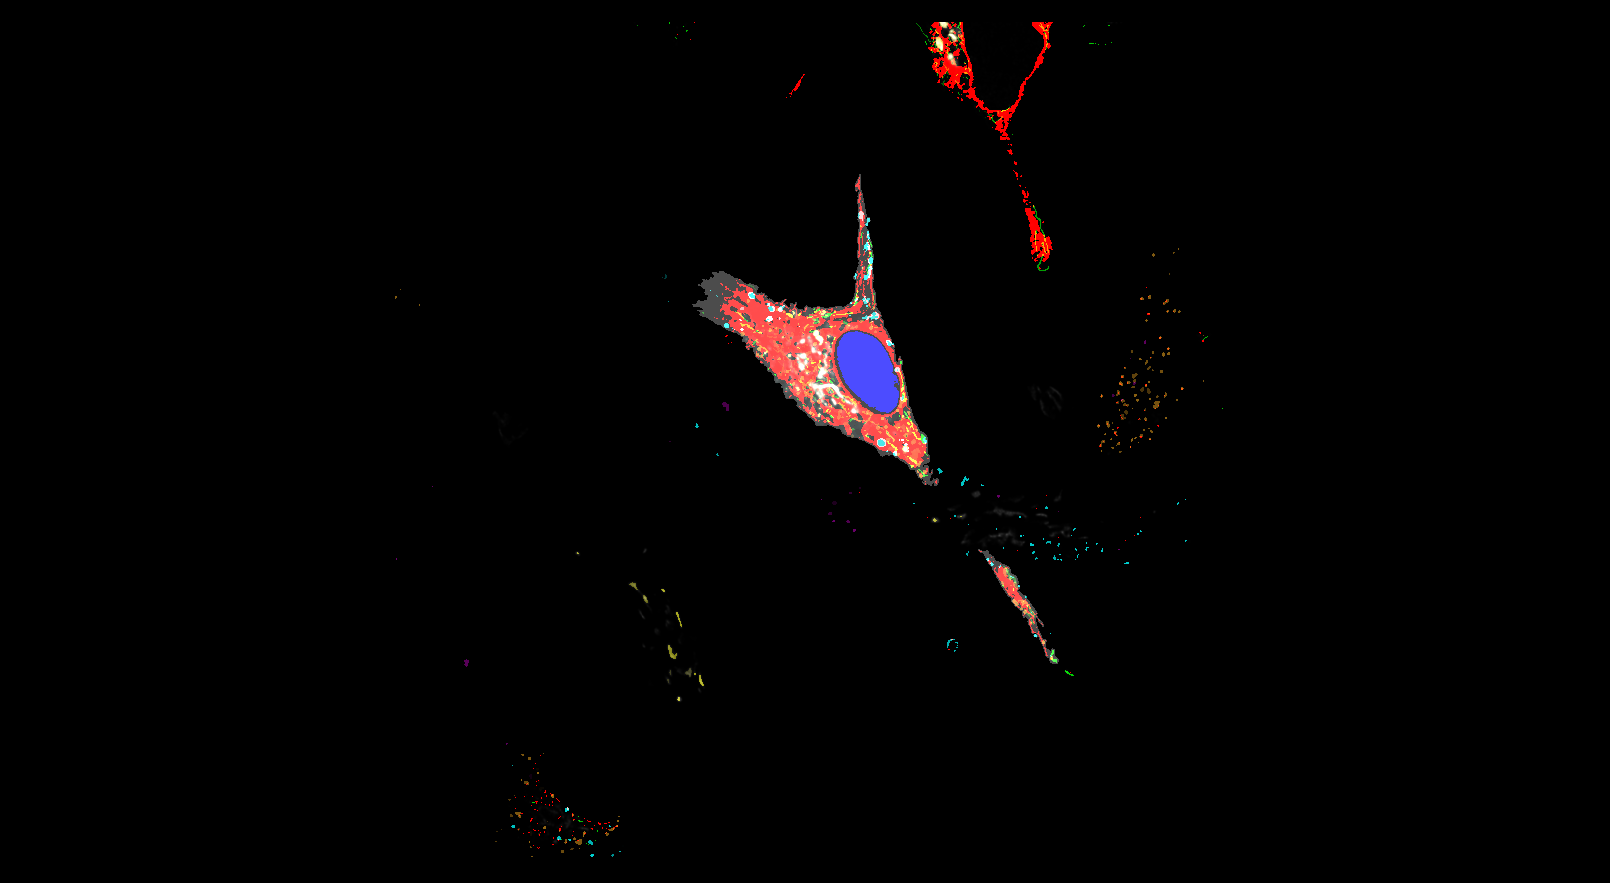

In [ ]:
viewer.add_image(cell_seg, colormap='gray', opacity=0.3, blending ='additive', scale = scale)

viewer.add_image(nuc_seg, colormap='blue', blending ='additive', scale = scale)
viewer.add_image(lyso_seg, colormap='cyan', blending ='additive', scale = scale)
viewer.add_image(mito_seg, colormap='green', blending ='additive', scale = scale)
viewer.add_image(golgi_seg, colormap='yellow', blending ='additive', scale = scale)
viewer.add_image(perox_seg, colormap='bop orange', blending ='additive', scale = scale)
viewer.add_image(ER_seg, colormap='red', blending ='additive', scale = scale)
viewer.add_image(LD_seg, colormap='magenta', blending ='additive', scale = scale)

nbscreenshot(viewer, canvas_only=True)

In [9]:
viewer.close()

-------------------------
# **regionprops**

To measure the amount, size, and shape of the individual organelles, we will utilize `skimage.measure.regionprops`. These measurements can be collected based on pixel/voxel units (assuming the image is isotropic in all dimensions) and or "real-world" units. Since most confocal microscope images are anisotropic (mostly with respect to the Z dimension), we will preferentially utilize real-world units. Luckily, regionprops>=0.20.0 has incorporated a spacing parameter that can handle anisotropic data.

Similar concepts will also be applied to measure the cell, cytoplasm, and nucleus below as well in notebook 1.4.

> ###### **Below, we have listed the properties that are supported in 3D and the properties that support scaling to real-world units**
> ###### 📝 **The regionprop property names correspond to 2D measurements even for those that are able to function in 3D (i.e. "area" is actually "volume" when a 3D image is being processed, etc.)**

In [10]:
labels = label(nuc_seg )
NUC_CH = 0
rp = regionprops(labels, intensity_image=raw_img_data[NUC_CH], spacing=scale)

supported = [] 
unsupported = []

for prop in rp[0]:
    try:
        rp[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties for 3D analysis:")
print("  " + "\n  ".join(supported))

Supported properties for 3D analysis:
  area
  area_bbox
  area_convex
  area_filled
  axis_major_length
  axis_minor_length
  bbox
  centroid
  centroid_local
  centroid_weighted
  centroid_weighted_local
  coords
  equivalent_diameter_area
  euler_number
  extent
  feret_diameter_max
  image
  image_convex
  image_filled
  image_intensity
  inertia_tensor
  inertia_tensor_eigvals
  intensity_max
  intensity_mean
  intensity_min
  label
  moments
  moments_central
  moments_normalized
  moments_weighted
  moments_weighted_central
  moments_weighted_normalized
  slice
  solidity


In [11]:
print("Properties only supported in 2D:")
print("  " + "\n  ".join(unsupported))

Properties only supported in 2D:
  eccentricity
  moments_hu
  moments_weighted_hu
  orientation
  perimeter
  perimeter_crofton


###### Below, we have listed the observed properties and the affect of scaling via real-world units (microns):

**Scaled**
>- volume: n * zyx
>- equivalent diameter: n * zyx**(1/3)
>- centroid-0: n * z
>- centroid-1: n * y
>- centroid-2: n * x
>- surface_area: varies by shape and orientation

**Not Scaled**
>- bbox (0-5)
>- euler_number
>- extent
>- max_intensity
>- mean_intensity
>- min_intensity
>- standard_deviation_intensity

# ***BUILD FUNCTION PROTOTYPE***

## **`0` - Apply Cell Mask**
To ensure we are performing single cell analysis, we will apply the cell segmentation as a mask.

> ###### 📝 **The Golgi body segmentation will be the example used throughout this notebook**

In [12]:
golgi_masked = apply_mask(golgi_seg, cell_seg)

## **`1` - Build the list of measurements we want to include from regionprops**

In [13]:
# start with LABEL
test_properties = ["label"]

# add position
test_properties = test_properties + ["centroid", "bbox"]

# add area
test_properties = test_properties + ["area", "equivalent_diameter"] # "num_pixels", 

# add shape measurements
test_properties = test_properties + ["extent", "euler_number", "solidity", "axis_major_length"] # "feret_diameter_max", "axis_minor_length"]

# add intensity values (used for quality checks only)
test_properties = test_properties + ["min_intensity", "max_intensity", "mean_intensity"]

test_properties

['label',
 'centroid',
 'bbox',
 'area',
 'equivalent_diameter',
 'extent',
 'euler_number',
 'solidity',
 'axis_major_length',
 'min_intensity',
 'max_intensity',
 'mean_intensity']

## **`2` - Add additional measurements as *"extra_properties"* with custom functions**

In [14]:
# create a function to include the standard deviation of intensities (for quality checks only)
def _standard_deviation_intensity(region, intensities):
    return np.std(intensities[region])

test_extra_properties = [_standard_deviation_intensity]

## **`3` - Run regionprops and export values as a pandas dataframe**

In [15]:
test_props = regionprops_table(golgi_masked,
                            intensity_image=raw_img_data[0], 
                            properties=test_properties,
                            extra_properties=test_extra_properties,
                            spacing=scale)

c:\Users\redre\anaconda3\envs\infer-subc-sample\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1825491516  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  6  Error-roundoff 8.1e-15  _one-merge 5.6e-14
  _near-inside 2.8e-13  Visible-distance 1.6e-14  U-max-coplanar 1.6e-14
  Width-outside 3.2e-14  _wide-facet 9.7e-14  _maxoutside 6.4e-14

  return convex_hull_image(self.image)
c:\Users\redre\anaconda3\envs\infer-subc-sample\lib\site-packages\skimage\measure\_regionprops.py:629: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
c:\Users\redre\anaconda3\envs\infer-subc-sample\lib\site-packages\skimage\measure\_regionprops.py:430: 

In [16]:
test_props_unscaled = regionprops_table(golgi_masked,
                            intensity_image=raw_img_data[0], 
                            properties=test_properties,
                            extra_properties=test_extra_properties)

c:\Users\redre\anaconda3\envs\infer-subc-sample\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1825525130  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  6  Error-roundoff 8.3e-15  _one-merge 5.8e-14
  _near-inside 2.9e-13  Visible-distance 1.7e-14  U-max-coplanar 1.7e-14
  Width-outside 3.3e-14  _wide-facet 1e-13  _maxoutside 6.7e-14

  return convex_hull_image(self.image)
c:\Users\redre\anaconda3\envs\infer-subc-sample\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0



In [17]:
test_props_table = pd.DataFrame(test_props)

test_org_name = "golgi"
test_props_table.insert(1, "object", test_org_name)
test_props_table.rename(columns={"area": "volume"}, inplace=True)

round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
test_props_table.insert(loc=2, column="scale", value=f"{round_scale}")

## **`4` - Add additional measurements**

- surface area
- surface area to volume ratio

In [18]:
# creating a function to measure the surface area of each object. This function utilizes "marching_cubes" to generate a mesh (non-pixelated object)
def _surface_area_from_props(labels: np.ndarray,
                             props: dict,
                             scale: Union[tuple, None]=None):
    """ 
    a function for getting surface area of volumetric objects

    Parameters:
    ----------
    lables:
        the segmentation np.ndarray with each object labeled a different number
    props:
        region props dictionary resulting from the _my_props_to_dict() function
    spacing:
        tuple of the dimension lengths in the same order as the dimension of your np.ndarray labels input
    """
    surface_areas = np.zeros(len(props["label"]))

    for index, lab in enumerate(props["label"]):
        # this seems less elegant than you might wish, given that regionprops returns a slice,
        # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
        volume = labels[
            max(props["bbox-0"][index] - 1, 0) : min(props["bbox-3"][index] + 1, labels.shape[0]),
            max(props["bbox-1"][index] - 1, 0) : min(props["bbox-4"][index] + 1, labels.shape[1]),
            max(props["bbox-2"][index] - 1, 0) : min(props["bbox-5"][index] + 1, labels.shape[2]),
        ]
        volume = volume == lab
        if scale is None:
            scale=(1.0,) * labels.ndim
        verts, faces, _normals, _values = marching_cubes(volume,
                                                         method="lewiner",
                                                         spacing=scale,
                                                         level=0)
        
        surface_areas[index] = mesh_surface_area(verts, faces)

    return surface_areas

In [19]:
# props["surface_area"] = surface_area_from_props(nuc_seg, props)
test_surface_area_tab = pd.DataFrame(_surface_area_from_props(golgi_masked, test_props, scale))

test_props_table.insert(12, "surface_area", test_surface_area_tab)
test_props_table.insert(14, "SA_to_volume_ratio", test_props_table["surface_area"].div(test_props_table["volume"]))

pd.set_option('display.max_columns', None)
test_props_table

,label,object,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,_standard_deviation_intensity
0,5,golgi,"(0.3961, 0.0799, 0.0799)",1.338514,53.079294,63.025804,3,660,786,5,668,792,2.031697,0.073417,27.673345,0.519517,0.302083,1,0.617021,1.219655,163.331863,1553.604126,561.029968,426.752930
1,8,golgi,"(0.3961, 0.0799, 0.0799)",1.584364,49.420571,67.709779,4,616,844,5,621,851,1.586601,0.075949,20.890426,0.525421,0.857143,1,inf,0.663578,656.176636,1564.505859,1051.939087,202.699020
2,9,golgi,"(0.3961, 0.0799, 0.0799)",3.142471,52.072793,68.042344,4,631,821,14,671,879,52.359505,5.842990,8.961081,2.234664,0.099483,0,0.274044,4.447854,220.876740,3970.933350,1176.995850,540.785583
3,10,golgi,"(0.3961, 0.0799, 0.0799)",2.014406,52.075192,59.932840,4,649,747,7,655,753,1.987595,0.088607,22.431611,0.553125,0.324074,1,0.744681,1.079486,460.174072,1865.534912,1085.212524,364.959747
4,11,golgi,"(0.3961, 0.0799, 0.0799)",1.584364,53.238780,63.685188,4,664,794,5,669,800,1.464170,0.068354,21.420449,0.507288,0.900000,1,inf,0.573976,470.528290,1260.845703,757.158936,196.661209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,138,golgi,"(0.3961, 0.0799, 0.0799)",5.545274,59.499755,69.489932,14,742,867,15,748,872,1.406250,0.063291,22.218930,0.494440,0.833333,1,inf,0.548105,45.250896,731.175659,247.360214,198.681442
89,139,golgi,"(0.3961, 0.0799, 0.0799)",5.545274,61.136613,75.587033,14,762,943,15,768,950,1.580408,0.070885,22.295227,0.513475,0.666667,1,inf,0.713376,306.154663,770.299744,488.885651,109.997253
90,140,golgi,"(0.3961, 0.0799, 0.0799)",5.545274,61.707663,76.189491,14,770,951,15,774,956,1.032763,0.035443,29.138920,0.407546,0.700000,1,inf,0.461961,56.950478,296.137421,112.887558,67.415947
91,141,golgi,"(0.3961, 0.0799, 0.0799)",5.545274,62.261470,80.726091,14,773,1007,15,786,1013,2.540682,0.129113,19.677997,0.627081,0.653846,1,inf,1.170058,82.592819,571.663818,301.497192,137.359604


# ***EXECUTE FUNCTION PROTOTYPE***

## **Define `get_org_morphology_3D()` function**

In [20]:
def _get_org_morphology_3D(segmentation_img: np.ndarray, 
                           seg_name: str, 
                           intensity_img, 
                           mask: np.ndarray, 
                           scale: Union[tuple, None]=None):
    """
    Parameters
    ------------
    segmentation_img:
        a 3D (ZYX) np.ndarray of segmented objects 
    seg_name: str
        a name or nickname of the object being measured; this will be used for record keeping in the output table
    intensity_img:
        a 3D (ZYX) np.ndarray contain gray scale values from the "raw" image the segmentation is based on )single channel)
    mask:
        a 3D (ZYX) binary np.ndarray mask of the area to measure from
    scale: tuple, optional
        a tuple that contains the real world dimensions for each dimension in the image (Z, Y, X)


    Regionprops measurements:
    ------------------------
    ['label',
    'centroid',
    'bbox',
    'area',
    'equivalent_diameter',
    'extent',
    'feret_diameter_max',
    'euler_number',
    'convex_area',
    'solidity',
    'axis_major_length',
    'axis_minor_length',
    'max_intensity',
    'mean_intensity',
    'min_intensity']

    Additional measurements:
    -----------------------
    ['standard_deviation_intensity',
    'surface_area']


    Returns
    -------------
    pandas dataframe of containing regionprops measurements (columns) for each object in the segmentation image (rows) and the regionprops object
    
    """
    ###################################################
    ## MASK THE ORGANELLE OBJECTS THAT WILL BE MEASURED
    ###################################################
    # in case we sent a boolean mask (e.g. cyto, nucleus, cellmask)
    input_labels = _assert_uint16_labels(segmentation_img)

    # mask
    input_labels = apply_mask(input_labels, mask)

    ##########################################
    ## CREATE LIST OF REGIONPROPS MEASUREMENTS
    ##########################################
    # start with LABEL
    properties = ["label"]

    # add position
    properties = properties + ["centroid", "bbox"]

    # add area
    properties = properties + ["area", "equivalent_diameter"] # "num_pixels", 

    # add shape measurements
    properties = properties + ["extent", "euler_number", "solidity", "axis_major_length"] # ,"feret_diameter_max", "axis_minor_length"]

    # add intensity values (used for quality checks)
    properties = properties + ["min_intensity", "max_intensity", "mean_intensity"]

    #######################
    ## ADD EXTRA PROPERTIES
    #######################
    def standard_deviation_intensity(region, intensities):
        return np.std(intensities[region])

    extra_properties = [standard_deviation_intensity]

    ##################
    ## RUN REGIONPROPS
    ##################
    props = regionprops_table(input_labels, 
                           intensity_image=intensity_img, 
                           properties=properties,
                           extra_properties=extra_properties,
                           spacing=scale)

    props_table = pd.DataFrame(props)
    props_table.insert(0, "object", seg_name)
    props_table.rename(columns={"area": "volume"}, inplace=True)

    if scale is not None:
        round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
        props_table.insert(loc=2, column="scale", value=f"{round_scale}")
    else: 
        props_table.insert(loc=2, column="scale", value=f"{tuple(np.ones(segmentation_img.ndim))}") 

    ##################################################################
    ## RUN SURFACE AREA FUNCTION SEPARATELY AND APPEND THE PROPS_TABLE
    ##################################################################
    surface_area_tab = pd.DataFrame(_surface_area_from_props(input_labels, props, scale))

    props_table.insert(12, "surface_area", surface_area_tab)
    props_table.insert(14, "SA_to_volume_ratio", props_table["surface_area"].div(props_table["volume"]))

    ################################################################
    ## ADD SKELETONIZATION OPTION FOR MEASURING LENGTH AND BRANCHING
    ################################################################


    return props_table

## **Run `_get_org_morphology_3D` function**

In [21]:
org_img = raw_img_data[0]
seg_name = 'golgi'
org_obj = golgi_seg
cell_mask = cell_seg

# with scale
golgi_table = _get_org_morphology_3D(segmentation_img=org_obj, seg_name=seg_name, intensity_img=org_img, mask=cell_mask, scale=scale)
# without scale
golgi_table_unscaled = _get_org_morphology_3D(segmentation_img=org_obj, seg_name=seg_name, intensity_img=org_img, mask=cell_mask, scale=None)

c:\Users\redre\anaconda3\envs\infer-subc-sample\lib\site-packages\skimage\measure\_regionprops.py:430: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1825558744  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  6  Error-roundoff 8.1e-15  _one-merge 5.6e-14
  _near-inside 2.8e-13  Visible-distance 1.6e-14  U-max-coplanar 1.6e-14
  Width-outside 3.2e-14  _wide-facet 9.7e-14  _maxoutside 6.4e-14

  return convex_hull_image(self.image)
c:\Users\redre\anaconda3\envs\infer-subc-sample\lib\site-packages\skimage\measure\_regionprops.py:629: RuntimeWarning: divide by zero encountered in scalar divide
  return self.area / self.area_convex
c:\Users\redre\anaconda3\envs\infer-subc-sample\lib\site-packages\skimage\measure\_regionprops.py:430: 

> **Table with scaled metrics**

In [22]:
golgi_table

,object,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,standard_deviation_intensity
0,golgi,5,"(0.3961, 0.0799, 0.0799)",1.338514,53.079294,63.025804,3,660,786,5,668,792,2.031697,0.073417,27.673345,0.519517,0.302083,1,0.617021,1.219655,163.331863,1553.604126,561.029968,426.752930
1,golgi,8,"(0.3961, 0.0799, 0.0799)",1.584364,49.420571,67.709779,4,616,844,5,621,851,1.586601,0.075949,20.890426,0.525421,0.857143,1,inf,0.663578,656.176636,1564.505859,1051.939087,202.699020
2,golgi,9,"(0.3961, 0.0799, 0.0799)",3.142471,52.072793,68.042344,4,631,821,14,671,879,52.359505,5.842990,8.961081,2.234664,0.099483,0,0.274044,4.447854,220.876740,3970.933350,1176.995850,540.785583
3,golgi,10,"(0.3961, 0.0799, 0.0799)",2.014406,52.075192,59.932840,4,649,747,7,655,753,1.987595,0.088607,22.431611,0.553125,0.324074,1,0.744681,1.079486,460.174072,1865.534912,1085.212524,364.959747
4,golgi,11,"(0.3961, 0.0799, 0.0799)",1.584364,53.238780,63.685188,4,664,794,5,669,800,1.464170,0.068354,21.420449,0.507288,0.900000,1,inf,0.573976,470.528290,1260.845703,757.158936,196.661209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,golgi,138,"(0.3961, 0.0799, 0.0799)",5.545274,59.499755,69.489932,14,742,867,15,748,872,1.406250,0.063291,22.218930,0.494440,0.833333,1,inf,0.548105,45.250896,731.175659,247.360214,198.681442
89,golgi,139,"(0.3961, 0.0799, 0.0799)",5.545274,61.136613,75.587033,14,762,943,15,768,950,1.580408,0.070885,22.295227,0.513475,0.666667,1,inf,0.713376,306.154663,770.299744,488.885651,109.997253
90,golgi,140,"(0.3961, 0.0799, 0.0799)",5.545274,61.707663,76.189491,14,770,951,15,774,956,1.032763,0.035443,29.138920,0.407546,0.700000,1,inf,0.461961,56.950478,296.137421,112.887558,67.415947
91,golgi,141,"(0.3961, 0.0799, 0.0799)",5.545274,62.261470,80.726091,14,773,1007,15,786,1013,2.540682,0.129113,19.677997,0.627081,0.653846,1,inf,1.170058,82.592819,571.663818,301.497192,137.359604


> **Table with unscaled metrics**

In [23]:
golgi_table_unscaled

,object,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,SA_to_volume_ratio,equivalent_diameter,extent,euler_number,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,standard_deviation_intensity
0,golgi,5,"(1.0, 1.0, 1.0)",3.379310,663.931034,788.344828,3,660,786,5,668,792,109.428345,29.0,3.773391,3.811827,0.302083,1,0.617021,11.502730,163.331863,1553.604126,561.029968,426.752930
1,golgi,8,"(1.0, 1.0, 1.0)",4.000000,618.166667,846.933333,4,616,844,5,621,851,96.725739,30.0,3.224191,3.855146,0.857143,1,inf,8.300227,656.176636,1564.505859,1051.939087,202.699020
2,golgi,9,"(1.0, 1.0, 1.0)",7.933709,651.341421,851.093154,4,631,821,14,671,879,3587.284424,2308.0,1.554283,16.396295,0.099483,0,0.274044,55.215131,220.876740,3970.933350,1176.995850,540.785583
3,golgi,10,"(1.0, 1.0, 1.0)",5.085714,651.371429,749.657143,4,649,747,7,655,753,101.824783,35.0,2.909280,4.058415,0.324074,1,0.744681,7.626731,460.174072,1865.534912,1085.212524,364.959747
4,golgi,11,"(1.0, 1.0, 1.0)",4.000000,665.925926,796.592593,4,664,794,5,669,800,88.261635,27.0,3.268949,3.722103,0.900000,1,inf,7.179456,470.528290,1260.845703,757.158936,196.661209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,golgi,138,"(1.0, 1.0, 1.0)",14.000000,744.240000,869.200000,14,742,867,15,748,872,83.068878,25.0,3.322755,3.627832,0.833333,1,inf,6.855853,45.250896,731.175659,247.360214,198.681442
89,golgi,139,"(1.0, 1.0, 1.0)",14.000000,764.714286,945.464286,14,762,943,15,768,950,92.804337,28.0,3.314441,3.767499,0.666667,1,inf,8.923114,306.154663,770.299744,488.885651,109.997253
90,golgi,140,"(1.0, 1.0, 1.0)",14.000000,771.857143,953.000000,14,770,951,15,774,956,53.755173,14.0,3.839655,2.990266,0.700000,1,inf,5.778338,56.950478,296.137421,112.887558,67.415947
91,golgi,141,"(1.0, 1.0, 1.0)",14.000000,778.784314,1009.745098,14,773,1007,15,786,1013,159.552704,51.0,3.128484,4.601052,0.653846,1,inf,14.635421,82.592819,571.663818,301.497192,137.359604


In [24]:
# Will result in FALSE because the _standard_deviation_intensity function was used in the prototyping 
# instead of the standard_deviation_intensity function from stats.py
golgi_table.equals(test_props_table)

False

## **Compare to finalized `get_org_morphology_3D` function**

In [ ]:
from infer_subc.utils.stats import get_org_morphology_3D

golgi_table_final = get_org_morphology_3D(segmentation_img=org_obj,
                                          seg_name='golgi',
                                          intensity_img=org_img, 
                                          mask=cell_mask, 
                                          scale=scale)

In [26]:
golgi_table.equals(golgi_table_final)

True